In order to run slicer with jupyter notebook firt pip_install('pip==new_version')
then pip_install('ipywidgets')

In [1]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
import pickle
import slicer
import JupyterNotebooksLib as slicernb
import json
import pandas as pd
import shutil
from slicer.ScriptedLoadableModule import *
from DICOMLib import DICOMUtils

slicernb.AppWindow.setWindowSize(scale=0.5)
slicernb.showSliceViewAnnotations(False)
#import matplotlib.pyplot as plt
#matplotlib.use('WXAgg')

#  Functions

In [2]:
import os
import subprocess
FILEBROWSER_PATH = os.path.join(os.getenv('WINDIR'), 'explorer.exe')

def explore(path):
    # explorer would choke on forward slashes
    path = os.path.normpath(path)

    if os.path.isdir(path):
        subprocess.run([FILEBROWSER_PATH, path])
    elif os.path.isfile(path):
        subprocess.run([FILEBROWSER_PATH, '/select,', os.path.normpath(path)])


In [3]:
def Appendtext(fname, text):
    with open(fname,'a+') as f:
        f.write(text)
    f.close()

## Directories 

In [69]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
log_file = join(data_long_dir, 'results', 'failed_conversion.txt')
input_dir = "F:\\CoBra\\Data\\volume_cross_nii\\input\\nii_files"
with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
with open(join(tables_dir, "sif_series_directories.pkl"), 'rb') as f:
    sif_volume_dir_dic = pickle.load(f)

    
inv_id_map = {v: k for k, v in id_dic.items()}
nii_files_dir = join("F:\\CoBra\\Data\\volume_cross_nii\\temp\\dcm2nii_conv_error")
failed_conv_files = [join(nii_files_dir, f) for f in os.listdir(nii_files_dir) if f.endswith('.nii.gz')]


#df_volume_dir = pd.read_csv(join(tables_dir, 'series_directories.csv'))
#sif_volume_dir_dic = pd.Series(
#    df_volume_dir.Directory.values, index=df_volume_dir.SeriesInstanceUID)\
#        .to_dict()

## Load dicoms into database

In [70]:
file_ids = [split(vol_file)[1][:6] for vol_file in failed_conv_files]
dcm_dirs = [dir_dic[inv_id_map[file_id]] for file_id in file_ids] 
for dcm_dir in dcm_dirs[:5]:
     DICOMUtils.importDicom(dcm_dir)

In [71]:
print("There are now",len(DICOMUtils.allSeriesUIDsInDatabase()),'files in the database')

There are now 137 files in the database


## Show predictions 

## Nifti

F:\CoBra\Data\volume_cross_nii\temp\dcm2nii_conv_error\070415.nii.gz
new_id = 070415


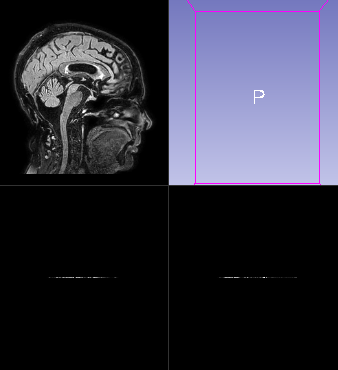

In [73]:
#### slicer.mrmlScene.Clear(False)
file_num = 0
examine_file_id = None#'008309
if not isinstance(examine_file_id, type(None)):
    vol_file = [f for f in failed_conv_files if examine_file_id in f][0]
    print(vol_file)
    file_id = examine_file_id
else:
    vol_file = failed_conv_files[file_num]
    file_id = split(vol_file)[1][:6]

volume = slicer.util.loadVolume(vol_file)
print(vol_file)
print('new_id =', file_id)
slicernb.ViewDisplay("")

In [67]:
shutil.move(vol_file, join(input_dir, file_id+'.nii.gz'))

'F:\\CoBra\\Data\\volume_cross_nii\\input\\nii_files\\291274.nii.gz'

In [33]:
text = 'cutoff'
text = '\n'+str(file_id) + ' ' + text
Appendtext(log_file, text)

## Dicom

F:\CoBra\Data\dcm\2019_07\91a3f60ea0bec27ab0b6f426559fc521\9a4c7984ce9b17a78d0574393ea19821
dcm_uid: 9a4c7984ce9b17a78d0574393ea19821
sif_dir: 2019_11\91a3f60ea0bec27ab0b6f426559fc521\9f7bac138e07f482d06bbef2b7d29056\MR\9a4c7984ce9b17a78d0574393ea19821


Geometric issues were found with 1 of the series. Please use caution.



Loading with imageIOName: GDCM
Window/level found in DICOM tags (center=223.92, width=442.12) has been applied to volume 702: CORT1 3D STEALTH +GD MPR - acquisitionNumber 7
Loading with imageIOName: GDCM
Window/level found in DICOM tags (center=223.92, width=442.12) has been applied to volume 702: CORT1 3D STEALTH +GD MPR - imageType ORIGINAL-PRIMARY-PROJECTION IMAGE-M-FFE
Loading with imageIOName: GDCM
Window/level found in DICOM tags (center=223.92, width=442.12) has been applied to volume 702: CORT1 3D STEALTH +GD MPR - imageOrientationPatient 1


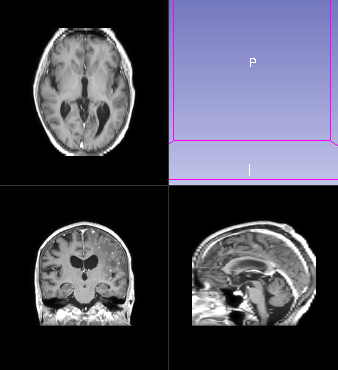

In [74]:
dcm_dir = dir_dic[inv_id_map[file_id]]
#dcm_files = [join(dcm_dir, file) for file in os.listdir(dcm_dir)]
dcm_uid = split(dcm_dir)[1]
print(dcm_dir)
print('dcm_uid:', dcm_uid)
print('sif_dir:', sif_volume_dir_dic[dcm_uid])
slicer.mrmlScene.Clear(False)
volume = DICOMUtils.loadSeriesByUID([dcm_uid])
slicernb.ViewDisplay()

In [75]:
print('num files on disk', len(os.listdir(join('F:\\CoBra\\Data\\dcm', dir_dic[dcm_uid]))))
print('num files on sif',len(os.listdir(join('Y:\\', sif_volume_dir_dic[dcm_uid]))))

num files on disk 64
num files on sif 64


In [18]:
print(split(split(vol_file)[0])[0])

F:\CoBra\Data\volume_longitudinal_nii


In [29]:
remove_niis_and_pred = True
if remove_niis_and_pred:
    os.remove(vol_file)
    os.remove(seg_file)
    os.remove(join(split(vol_file)[0], file_id+'_seg.nii.gz'))
    os.remove(join(split(split(vol_file)[0])[0], 'input', 'nii_files', file_id+'.nii.gz'))

## Dynamic 3d 

In [11]:
slicernb.showVolumeRendering(volume, show=True)
app = slicernb.AppWindow()
app

TypeError: GetFirstVolumeRenderingDisplayNode argument 1: method requires a VTK object